# Visualization & Analysis of Chemical Data
This week we will look at a few ways to visualize and analyze chemical data. We already learned some ways to analyze chemical data in weeks 5 and 6 when we got familiar with RDKit. Visualizing through smart ways of plotting data is also a very important part of data analysis, which allows you to get a feeling of your data and to identify patterns.

Frst, let's get some housekeeping out of the way. We will use the same data as in weeks 5 and 6 from ChEMBL and filter it right away by excluding data with missing SMILES and USAN Definitions.

In [1]:
# some imports
from rdkit import Chem
from rdkit.Chem import PandasTools
import pandas as pd
from pathlib import Path
import os

In [2]:
# load data
current_file = Path(os.path.abspath(''))
csv_file = current_file.parent / "week_05" / "chembl_drugs.csv"
df = pd.read_csv(csv_file, sep= ";")
df.head()

,Parent Molecule,Name,Synonyms,Research Codes,Phase,Drug Applicants,USAN Stem,USAN Year,USAN Definition,USAN Stem - Substem,...,Passes Rule of Five,First In Class,Chirality,Prodrug,Oral,Parenteral,Topical,Black Box,Availability Type,Smiles
0,CHEMBL492491,FENVALERATE,BELMARK|FENVALERATE|PHENVALERATE|PYDRIN|S-5602...,S-5602|SD-43775|WL-43775,-1.0,NaN,NaN,NaN,NaN,NaN,...,0,0,Racemic Mixture,0,0,0,0,0,Unknown,CC(C)C(C(=O)OC(C#N)c1cccc(Oc2ccccc2)c1)c1ccc(C...
1,CHEMBL2103777,THIOPHANATE,NSC-170810|THIOPHANATE,NSC-170810,-1.0,NaN,NaN,NaN,NaN,NaN,...,1,0,Achiral Molecule,0,0,0,0,0,Unknown,CCOC(=O)NC(=S)Nc1ccccc1NC(=S)NC(=O)OCC
2,CHEMBL1868702,GESTRINONE,A 46 745|A-46-745|A-46745|DIMETRIOSE|GESTRINON...,A 46 745|A-46-745|A-46745|R 2323|R-2323|RU 232...,4.0,NaN,'-estr-; -rinone',1978.0,estrogens; cardiotonics (amrinone type),'-estr-(-estr-); -rinone(-rinone)',...,1,0,Single Stereoisomer,0,0,0,0,0,Unknown,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CCC4=C3C=...
3,CHEMBL2104213,DESMENINOL,DESMENINOL|METHIONINE HYDROXY ANALOG,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,...,1,0,Racemic Mixture,0,0,0,0,0,Unknown,CSCCC(O)C(=O)O
4,CHEMBL1904952,QUAZODINE,MJ 1988|MJ-1988|QUAZODINE,MJ 1988|MJ-1988,-1.0,NaN,NaN,1968.0,NaN,NaN,...,1,0,Achiral Molecule,0,0,0,0,0,Unknown,CCc1ncnc2cc(OC)c(OC)cc12


If you get the following error in the next cell:
```
AttributeError: module 'pandas.io.formats.format' has no attribute 'get_adjustment'
```
Install pandas version 2.1 with the following command:
```
!pip install pandas==2.1
```

In [3]:
# remove the rows with NaN values for SMILES and USAN Definition
df = df.dropna(subset=["Smiles", "USAN Definition"])
# add molecule objects to the df from SMILES
PandasTools.AddMoleculeColumnToFrame(df, smilesCol="Smiles", molCol="mol")

In [4]:
df['USAN Definition'].unique()

array(['estrogens; cardiotonics (amrinone type)', 'sympathomimetics',
       'alpha-adrenoceptor antagonists (benzodioxane derivatives)',
       'fibrinogen receptor antagonists (glycoprotein IIb/IIIa receptor antagonists)',
       'antineoplastics (chloroethylamine derivatives)', 'antiandrogens',
       'endopeptidase inhibitors',
       'quaternary ammonium derivatives; quaternary ammonium derivatives',
       'anti-inflammatory agents (salicylic acid derivatives)',
       'quaternary ammonium derivatives', 'antidiabetics', 'estrogens',
       'prostaglandins', 'antivirals',
       'antihyperlipidemics (clofibrate type)',
       '5-nitrofuran derivatives',
       'coronary vasodilators (verapamil type)',
       'iodine-containing contrast media',
       'anti-inflammatory/analgesic agents (ibuprofen type)',
       'cholinesterase inhibitors (physostigmine type)',
       'bronchodilators (phenethylamine derivatives)',
       'anti-inflammatory agents (acetic acid derivatives)',
      

For the purpose of this exercise we will filter out some specific drugs based on their USAN definition. We picked these four mode of actions: *antivirals*, *analgesics*, *beta-blockers* and *anti-inflammatory* drugs. We will keep any data point that has these words in their description and then make four new super classes out of them stored in `application`. You are free to choose different classes and test the influence on the results below. Depending on the homogeneity of the groups the clustering will give very different results.

In [5]:
drug_applications = ['antivirals', 'analgesics', 'beta-blockers','anti-inflammatory']
# df matches one of the applications (not contains but exact match)
df = df[df['USAN Definition'].str.contains('|'.join(drug_applications), case=False, na=False)]
# add a column with the application combining all antivirals etc. into one class each
df['application'] = df['USAN Definition'].apply(lambda x: [app for app in drug_applications if app in x.lower()][0])

## Principal Component Analysis (PCA)
Principal Component Analysis (PCA) is a technique used to emphasize variation and bring out strong patterns in a dataset. It's often used to make data easy to explore and visualize. It is also used for dimensionality reduction, which is useful when you have a lot of features describing your data. PCA is a linear transformation method that finds the directions (principal components) that maximize the variance in the data. These directions are orthogonal to each other and form a new coordinate system in which the data can be represented. The first principal component is the direction in which the data varies the most, the second principal component is the direction in which the data varies the second most, and so on. We will plot the first two principal components of the data and thus reduce the dimnesionality of the data (going from n to 2 dimensions). For more details have a look at [this blog post](https://towardsdatascience.com/principal-component-analysis-pca-explained-visually-with-zero-math-1cbf392b9e7d).

We will perform PCA on Morgan fingerprints as features and make use of an the package `molplotly`, which allows plotting data interactively!

In [6]:
!pip install molplotly
!pip install dash==2.10
!pip install scikit-learn

In [7]:
# more imports
import numpy as np
from rdkit.Chem import AllChem, DataStructs
from sklearn.decomposition import PCA

### Carry out PCA algorithm

In [8]:
def smi_to_fp(smi):
    '''
    Function to convert SMILES to Morgan fingerprint
    '''
    fp = AllChem.GetMorganFingerprintAsBitVect(
        Chem.MolFromSmiles(smi), 2, nBits=2048)
    arr = np.zeros((0,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [9]:
# convert SMILES to Morgan fingerprints
df['fp'] = df['Smiles'].apply(smi_to_fp)
fps = np.array(df['fp'].tolist())

Look up [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) how to use `sklearn`'s PCA.

In [10]:
# instantiate PCA class with 2 (principal) components
pca = PCA(n_components=2)
# fit our data (fingerprints)
components = pca.fit_transform(fps.reshape(-1, 2048))
# store components in dataframe
df['PCA-1'] = components[:, 0]
df['PCA-2'] = components[:, 1]

### Plot the first two principal components
We already now how to plot data in a straight-forward way using `matplotlib`. While, it is very flexible we have very complex data and would like to see the influence of the molecular structure on the results. Therefore, we will look into the package[ `molplotly`](https://github.com/wjm41/molplotly/tree/main), which allows interactive plotting including much more information.

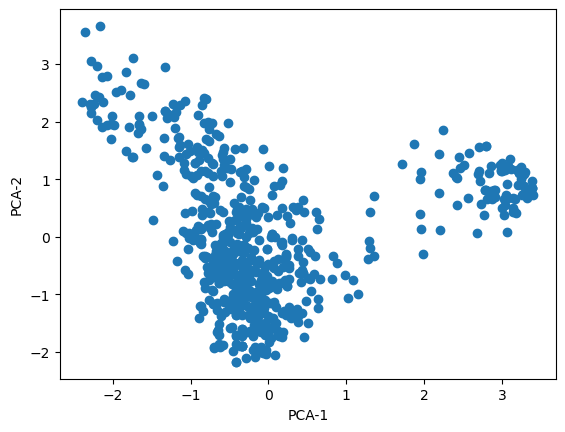

In [11]:
import matplotlib.pyplot as plt

# plot the PCA components in a scatter plot
fig, ax = plt.subplots()
scatter = ax.scatter(df['PCA-1'], df['PCA-2'])
ax.set_xlabel('PCA-1');
ax.set_ylabel('PCA-2');

This is the most basic implementation of such a PCA plot. If you like you can try to populate with more data such as colouring by drug types. In the next step we will look at how this is done with [`molplotly`](https://github.com/wjm41/molplotly/tree/main).

In [12]:
import plotly.express as px
import molplotly

# instantiate the plot as done with the base package plotly
fig_pca = px.scatter(df, # data to pull from
                     x="PCA-1", # x-axis
                     y="PCA-2", # y-axis
                     color='application', # color by application
                     title='PCA of morgan fingerprints', # title of the plot
                     labels={'color': 'application'}, # label for the color legend
                     width=1200,
                     height=800)

# populate with molecule information
app_pca = molplotly.add_molecules(fig=fig_pca,  # figure to populate
                                  df=df,  # dataframe with molecule information
                                  smiles_col='Smiles',  # column with SMILES
                                  title_col='Name',  # column to take the name for the molecule when hovering over it
                                  caption_cols=['application', 'USAN Definition'], # columns to take the additional captions from
                                  color_col='application', # column to color by
                                  show_coords=False)

# show the plot: don't use the same port several times as it will overwrite the previous one
app_pca.run_server(mode='inline', port=8100, height=850)

Dash is running on http://127.0.0.1:8100/



Now, this plot is already much more informative. We can see the different drug groups and when hovering over the plot we can see the molecule the data point represents including the full USAN Definition and the name of the drug. We can also zoom in and out again!

This plot showed colouring based on discrete groups. What happens when we want to plot a continuous variable? We will look into this in the next section by calculating the logP of all the molecules.

In [13]:
from rdkit.Chem import Descriptors
df["LogP"] = df["mol"].apply(lambda x: Descriptors.MolLogP(x))


In [14]:
import plotly.express as px
import molplotly
fig_pca = px.scatter(df,
                     x="PCA-1",
                     y="PCA-2",
                     color='LogP',
                     title='PCA of morgan fingerprints',
                     labels={'color': 'LogP'},
                     width=1200,
                     height=800)

app_pca = molplotly.add_molecules(fig=fig_pca,
                                  df=df,
                                  smiles_col='Smiles',
                                  title_col='Name',
                                  caption_cols=['application', 'LogP'],
                                  color_col='LogP',
                                  show_coords=False)

app_pca.run_server(mode='inline', port=8200, height=850)

Dash is running on http://127.0.0.1:8200/



This looks interesting too! However, we can see that there are some outliers that make the visulaization not so informative (and a s a side note also are not clustered very well with their group). Let's exclude those points and look at the plot again.

In [15]:
# filter out logP below -5 and above 5
df_fil = df[(df['LogP'] > -5) & (df['LogP'] < 5)]

In [16]:
import plotly.express as px
import molplotly
fig_pca = px.scatter(df_fil,
                     x="PCA-1",
                     y="PCA-2",
                     color='LogP',
                     title='PCA of morgan fingerprints',
                     labels={'color': 'LogP'},
                     width=1200,
                     height=800)

app_pca = molplotly.add_molecules(fig=fig_pca,
                                  df=df_fil,
                                  smiles_col='Smiles',
                                  title_col='Name',
                                  caption_cols=['application', 'LogP'],
                                  color_col='LogP',
                                  show_coords=False)

app_pca.run_server(mode='inline', port=8300, height=850)

Dash is running on http://127.0.0.1:8300/



In this last plot the differences in logP can be more easily observed. We can see that there is some trend that the clustering coincides with the logP. This is a very interesting observation but much more analysis would have to be done to get to the depths of this. This is a very simple example of how to use PCA to visualize and analyze chemical data. There are many more ways to use PCA and many more ways to visualize the data. We will look at some more in the next section.

## Clustering
Clustering data is a way to group data points that are similar to each other. There are many different clustering algorithms, and we will look at the k-means algorithm and the Taylor-Butina algorithm. Clsutering is mostly used when we don't know the underlying data structure and need it for analysis or data processing. Another use case is evaluating how meaningful our chosen representation (in our case the Morgan fingerprint) in the given context (here drug actions) is.

### K-means clustering
First, we will look into clustering using the k-means algorithm, which is simple and widely used. It tries to find cluster centers that are representative of certain regions of the data. The algorithm alternates between assigning data points to the nearest cluster center (based on some distance function) and updating cluster centers to be the mean of the data points that are assigned to them. We will use the [`KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) class from the `sklearn` package to perform k-means clustering.

In [17]:
# eben more imports
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [18]:
# define number of clusters based on number of drug actions
num_clusters = 4
# instantiate KMeans object
km = KMeans(n_clusters=num_clusters, # number of clusters
            random_state=42, # random seed for initializing the centroids; keep the same for reproducibitliy
            n_init='auto') # number of initializations of centroids
# fit data
km.fit(df['fp'].tolist())
# predict cluster number on our data
clusters = km.predict(df['fp'].tolist())

In [19]:
# store in dataframe
df['cluster'] = clusters
# convert to strings (so that it recognizes this as discrete classes)
df['cluster'] = df['cluster'].astype(str)

In [20]:
# plot the pca and color by cluster
fig_pca_clusters = px.scatter(df,
                              x="PCA-1",
                              y="PCA-2",
                              color='cluster',
                              title='PCA of morgan fingerprints',
                              labels={'color': 'cluster'},
                              width=1200,
                              height=800)


app_pca_clusters = molplotly.add_molecules(fig=fig_pca_clusters,
                                             df=df,
                                             smiles_col='Smiles',
                                             title_col='Name',
                                             caption_cols=['USAN Definition'],
                                             color_col='cluster',
                                             show_coords=False)

app_pca_clusters.run_server(mode='inline', port=8400, height=850)

Dash is running on http://127.0.0.1:8400/



Nice! If we compare to the previous plots, there certainly is some overlap with the true clusters. However, we also can see that it is far from perfect. This can have a multitude of reasons. Our drug classes contain heterogenous data, the Morgan fingerprints might not be the best representation of the data, or the clustering algorithm might not be the best choice. We will look into one of the classes next and see how diverse even one class is. Remember that we also comboned several USAN Definitions to simplify things. Thus, different molecule classes (defined by chemical motifs) were taken together.

#### Finding number of clusters
In the example above, we knew how many clusters we have in our data so we could help the algorithm by already supplying it with the right number. Now, we will look into how to find the right number of clusters in an unsupervised (without true labels) way and try to cluster the subgroup of all anti-inflammatory drugs. 

We will use the Silhouette score to find the optimal number of clusters. The Silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The score ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. We will calculate the Silhouette score for different numbers of clusters and choose the number of clusters that gives the highest score.

In [21]:
# get all the anti-inflammatory drugs
antiinfl = df[df['application'] == 'anti-inflammatory'].copy()
antiinfl.head()

,Parent Molecule,Name,Synonyms,Research Codes,Phase,Drug Applicants,USAN Stem,USAN Year,USAN Definition,USAN Stem - Substem,...,Black Box,Availability Type,Smiles,mol,application,fp,PCA-1,PCA-2,LogP,cluster
25,CHEMBL2107288,TROLAMINE SALICYLATE,NEO HELIOPAN TS|NEOTAN W|TEA-SALICYLATE|TROLAM...,NaN,-1.0,NaN,'sal-',NaN,anti-inflammatory agents (salicylic acid deriv...,'sal-(sal-)',...,0,Unknown,O=C(O)c1ccccc1O.OCCN(CCO)CCO,<rdkit.Chem.rdchem.Mol object at 0x124c9f760>,anti-inflammatory,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-0.453423,-1.979884,-0.6443,3
30,CHEMBL2107494,TENOSAL,TENOSAL,NaN,-1.0,NaN,'-sal',NaN,anti-inflammatory agents (salicylic acid deriv...,'-sal(-sal)',...,0,Unknown,O=C(Oc1ccccc1C(=O)O)c1cccs1,<rdkit.Chem.rdchem.Mol object at 0x124d20510>,anti-inflammatory,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.120227,-1.700780,2.6655,3
36,CHEMBL2105451,PARCETASAL,MR-897|PARCETASAL,MR-897,-1.0,NaN,'-sal',NaN,anti-inflammatory agents (salicylic acid deriv...,'-sal(-sal)',...,0,Unknown,CC(=O)Nc1ccc(OC2(C)OC(=O)c3ccccc3O2)cc1,<rdkit.Chem.rdchem.Mol object at 0x124d203c0>,anti-inflammatory,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.210031,-0.759094,2.9469,3
41,CHEMBL2104464,VEDAPROFEN,CERM 10202|CERM-10202|PM 150|PM-150|QUADRISOL|...,CERM 10202|CERM-10202|PM 150|PM-150,-1.0,NaN,'-profen',1994.0,anti-inflammatory/analgesic agents (ibuprofen ...,'-profen(-profen)',...,0,Unknown,CC(C(=O)O)c1ccc(C2CCCCC2)c2ccccc12,<rdkit.Chem.rdchem.Mol object at 0x124d20580>,anti-inflammatory,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-0.068706,-0.789493,5.0756,3
54,CHEMBL33958,CLOFURAC,CLOFURAC|Clofurac,NaN,-1.0,NaN,'-ac',NaN,anti-inflammatory agents (acetic acid derivati...,'-ac(-ac)',...,0,Unknown,O=C1Cc2cc(Cl)c(C3CCCCC3)cc2O1,<rdkit.Chem.rdchem.Mol object at 0x124d206d0>,anti-inflammatory,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-0.900162,0.136979,3.8492,3


In [22]:
# let's cluster the data with a random guess of numbers of clusters
num_clusters = 10
km = KMeans(n_clusters=num_clusters,random_state=42,n_init='auto')
km.fit(antiinfl['fp'].tolist())
clusters = km.predict(antiinfl['fp'].tolist())
antiinfl['cluster'] = clusters
# convert to strings
antiinfl['cluster'] = antiinfl['cluster'].astype(str)

In [23]:
# we need to repeat the PCA for the subselection of data
pca = PCA(n_components=2)
fsp_antinfl = np.array(antiinfl['fp'].tolist())
components = pca.fit_transform(fsp_antinfl.reshape(-1, 2048))
antiinfl['PCA-1'] = components[:, 0]
antiinfl['PCA-2'] = components[:, 1]

Show another interactive plot and color by newly determined cluster identity.

In [24]:
fig_pca = px.scatter(antiinfl,
                     x="PCA-1",
                     y="PCA-2",
                     color='cluster',
                     title='PCA of morgan fingerprints',
                     labels={'color': 'cluster'},
                     width=1200,
                     height=800)

app_pca = molplotly.add_molecules(fig=fig_pca,
                                  df=antiinfl,
                                  smiles_col='Smiles',
                                  title_col='Name',
                                  caption_cols=['USAN Definition'],
                                  color_col='cluster',
                                  show_coords=False)

app_pca.run_server(mode='inline', port=8500, height=850)

Dash is running on http://127.0.0.1:8500/



Looks good! Let's have a more rational approach on determining the number of clusters. We will iterate over a range of 3 to 34 number of clusters and calculate the [`silhouette score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). We will choose the number of clusters where the silhouette score is the highest. We can also plot the silhouette score over the cluster size.

In [25]:
cluster_range = range(3,35)
score_list = []
for k in cluster_range:
    # instantiate KMeans class
    km = KMeans(n_clusters=k,random_state=42,n_init='auto')
    # fit and predict km at the same time based on the fingerprints
    cluster_labels = km.fit_predict(antiinfl['fp'].tolist())
    # calculate the silhouette score
    score = silhouette_score(antiinfl['fp'].tolist(),cluster_labels)
    score_list.append([k,score])

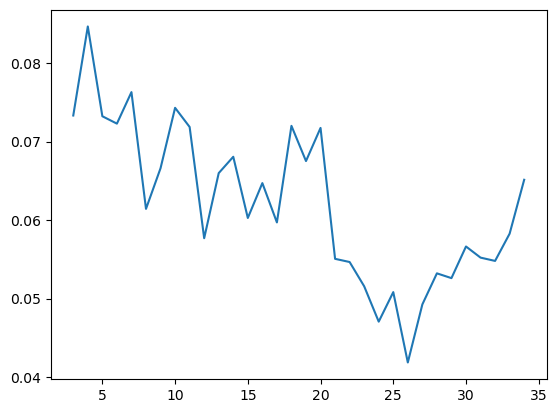

In [26]:
# plot silhouette score over number of clusters
score_df = pd.DataFrame(score_list,columns=['k','silhouette_score'])
fig, ax = plt.subplots()
ax.plot(score_df['k'],score_df['silhouette_score']);

In [27]:
# let's determine the optimal cluster size programmatically
num_clusters_opt = score_df[score_df['silhouette_score'] == score_df['silhouette_score'].max()]['k'].values[0]
num_clusters_opt

4

We have the optimal cluster number determined to be 4. We can rerun the k-means algorithm with the optimal number of clusters.

In [28]:
km_opt = KMeans(n_clusters=num_clusters_opt, random_state=42, n_init="auto")
clusters_opt = km_opt.fit_predict(antiinfl['fp'].tolist())
antiinfl['cluster_opt'] = clusters_opt
# convert to strings
antiinfl['cluster_opt'] = antiinfl['cluster_opt'].astype(str)

In [29]:
import plotly.express as px
import molplotly
fig_pca = px.scatter(antiinfl,
                     x="PCA-1",
                     y="PCA-2",
                     color='cluster_opt',
                     title='PCA of morgan fingerprints',
                     labels={'color': 'cluster_opt'},
                     width=1200,
                     height=800)

app_pca = molplotly.add_molecules(fig=fig_pca,
                                  df=antiinfl,
                                  smiles_col='Smiles',
                                  title_col='Name',
                                  caption_cols=['USAN Definition'],
                                  color_col='cluster_opt',
                                  show_coords=False)

app_pca.run_server(mode='inline', port=8600, height=850)

Dash is running on http://127.0.0.1:8600/



This looks pretty convincing. We can see that the clustering is much better than before. However, we can also see that there are still some data points that are still clustered in a weird way. This is a very common problem in clustering and can have many reasons but does not mean that anything went wrong with the clustering. As mentioned the before, the data representation has a huge influence but also the way that we visualize it is important. We will look into another clustering algorithm in the next section to see a last approach.

### Taylor-Butina clustering
Now. let's look at a different clustering algorithm, the Taylor-Butina clustering algorithm. This algorithm is based on the Tanimoto similarity between fingerprints so that all molecules in a cluster are more similar to the centroid than a pre-defined threshold but are potentially less similar to each other. This should result in small but homogenuous clusters. The steps to the algorithm are:
1. Calculate a fingerprint (e.g. Morgan fingerprint) for each molecule in the dataset.
2. Calculate the Tanimoto distance matrix
3. Cluster with the Taylor-Butina algorithm: 
    1. Centroids are initiated and sorted based on number of neighbors (Tanimoto similarity above (distance below) certain threshold).
    2. The centroid with the most neighbors gets all those assigned in its cluster.
    3. Move to the next biggest centroid group and assign.
    4. Repeat until no molecules with neighbors left (can have singletons - molecules without neighbors not assigned to a cluster)

With this algorithm one can get molecules in one cluster that are actually more similar to another cluster's centroid but were first assigned the biggest one. Thus, the choice of threshold is an important parameter to tune.

In [30]:
from rdkit.ML.Cluster import Butina
from rdkit.Chem import rdMolDescriptors

In [31]:
mols = antiinfl['mol'].tolist()

#### 1. Calculate fingerprints for all molecules in the dataset.
We have done this many times before. Let's to it again using a list comprehension in one line of code.

As a reminder - the structure of a list comprehension is:
```
[function(item) for item in iterable]
```


In [33]:
fp_list =  [rdMolDescriptors.GetMorganFingerprintAsBitVect(m, 2, nBits=2048) for m in mols]
len(fp_list), len(mols)

(238, 238)

In [35]:
# check data type of the first element
assert type(fp_list[0]) == DataStructs.cDataStructs.ExplicitBitVect

#### 2. Calculate the Tanimoto distance matrix

We will use the [`DataStructs.BulkTanimotoSimilarity`](http://www.dalkescientific.com/writings/diary/archive/2020/10/02/using_rdkit_bulktanimotosimilarity.html) function from the `rdkit` package to calculate the Tanimoto similarity between all pairs of fingerprints. The Tanimoto similarity is a measure of how similar two sets are so we need to convert to distances by subtracting from 1 after.

This function calculates the Tanimoto similarity between all pairs of fingerprints in the dataset. The output is a list of lists where the element at position (i, j) is the Tanimoto similarity between the fingerprints of molecule i and molecule j. Try to get the Tanimoto distance between the first molecule to all the others (including intself).

In [39]:
sims = DataStructs.BulkTanimotoSimilarity(fp_list[0],fp_list[:])
sims

[1.0,
 0.28888888888888886,
 0.15517241379310345,
 0.16981132075471697,
 0.05263157894736842,
 0.1125,
 0.15,
 0.13725490196078433,
 0.16363636363636364,
 0.43902439024390244,
 0.15517241379310345,
 0.3,
 0.14814814814814814,
 0.2,
 0.14285714285714285,
 0.23529411764705882,
 0.42424242424242425,
 0.13725490196078433,
 0.22,
 0.12962962962962962,
 0.22,
 0.15384615384615385,
 0.1694915254237288,
 0.18,
 0.24,
 0.23404255319148937,
 0.1,
 0.234375,
 0.13432835820895522,
 0.2978723404255319,
 0.06349206349206349,
 0.18,
 0.1206896551724138,
 0.19607843137254902,
 0.2826086956521739,
 0.24561403508771928,
 0.15625,
 0.17647058823529413,
 0.21818181818181817,
 0.11666666666666667,
 0.16326530612244897,
 0.125,
 0.14035087719298245,
 0.13333333333333333,
 0.11764705882352941,
 0.18333333333333332,
 0.18518518518518517,
 0.3125,
 0.125,
 0.13559322033898305,
 0.18181818181818182,
 0.15789473684210525,
 0.1111111111111111,
 0.3333333333333333,
 0.15517241379310345,
 0.14035087719298245,
 0.18

We can see that the first element, as expected, gives similarity of one since it is the same molecule. The other values are between 0 and 1. The closer to 1 the more similar the molecules are. The function returns a list. We will build this list so that is a triangular distance matrix in the form of a list (so all rows are not the same length and concatenated). Write a loop to calculate the Tanimoto distance matrix where at every step you calculate the similarities between the current element and all *previous* elements.

In [41]:
dists = []
nfps = len(fp_list)
for i in range(1,nfps):
    sims = DataStructs.BulkTanimotoSimilarity(fp_list[i],fp_list[:i])
    # convert similarity to dinstance (1-x)
    dists.extend([1-x for x in sims])
len(dists)

28203

#### 3. Apply the Taylor-Butina algorithm

Check out the function docs [here](https://www.rdkit.org/docs/source/rdkit.ML.Cluster.Butina.html). The arguments that need to be passed are the following:
- `distances`: The distance matrix calculated in the previous step.
- `n`: The number of molecules in the dataset.
- `cutoff`: The Tanimoto similarity threshold to assign molecules to a cluster.
- `isDistData`: A boolean indicating whether the input is a distance matrix or similarity matrix.

In [47]:
mol_clusters = Butina.ClusterData(
    data = dists,
    nPts = nfps,
    distThresh = 0.35,
    isDistData = True
    )
len(mol_clusters), type(mol_clusters)

(191, tuple)

Great! Now we have all the necessary parts to combine it all in one function that takes in as arguments the list of molecules and a given threshold and returns the list of cluster IDs (corresponding to the molecule list) and a the returned tuple of cluster indices sorted by cluster size.

In [32]:
def butina_cluster(mol_list,cutoff=0.35):
    '''
    Carry out Tayloer-Butina algorithm.

    :param mol_list: list of RDKit molecules
    :param cutoff: Tanimoto cutoff value for clustering

    :return: list of cluster IDs for each molecule, dictionary with cluster ID -> [molecule indices]
    '''
    # 1. get fingerprint
    fp_list = [rdMolDescriptors.GetMorganFingerprintAsBitVect(m, 2, nBits=2048) for m in mol_list]
    dists = []
    nfps = len(fp_list)
    # 2. get tanimoto distance matrix
    for i in range(1,nfps):
        sims = DataStructs.BulkTanimotoSimilarity(fp_list[i],fp_list[:i])
        # convert similarity to dinstance (1-x)
        dists.extend([1-x for x in sims])
    # 3. apply Taylor-Butina algorithm (the rest happens under the hood)
    mol_clusters = Butina.ClusterData(dists,nfps,cutoff,isDistData=True)
    cluster_id_list = [0]*nfps
    for idx,cluster in enumerate(mol_clusters,1):
        for member in cluster:
            cluster_id_list[member] = idx
    # get tuple sorted: cluster_id -> [molecule indices]
    mol_clusters = sorted(mol_clusters, key=len, reverse=True)
    return cluster_id_list, mol_clusters

In [33]:
antiinfl['butina_cluster'], cluster_dict = butina_cluster(mols)

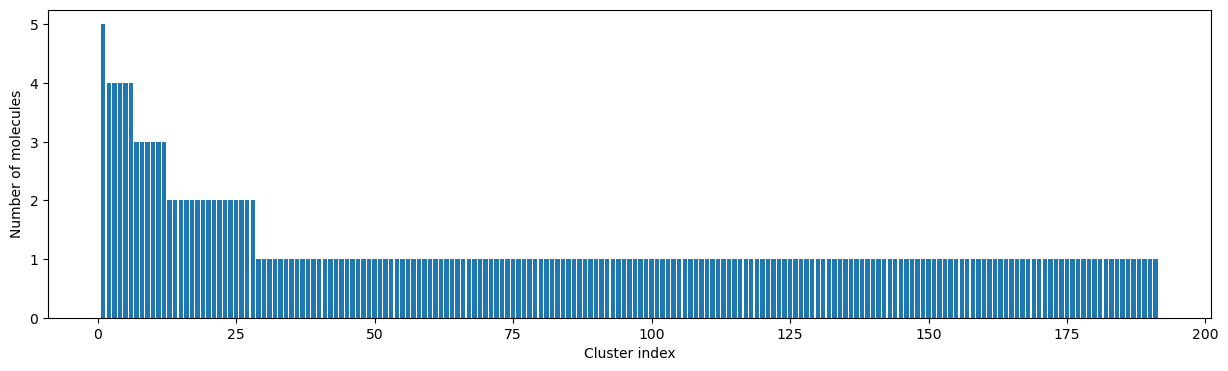

In [34]:
# Plot the size of the clusters vs. their index
fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("Number of molecules")
ax.bar(range(1, len(cluster_dict) + 1), [len(c) for c in cluster_dict], lw=5);

We already addressed that the threshold determines how the clusters are built and is thus a parameter worth exploring. Before, we chose a random threshold (default value of 0.35) and can see that this clustering does not give good cluster sizes. In the following cell we will iterate over a range of thresholds and plot the cluster sizes sorted by size. Based on that we can select our optimal threshold. We want a smooth distribution while at the same time have as little singletons (clusters with one data point) as possible.

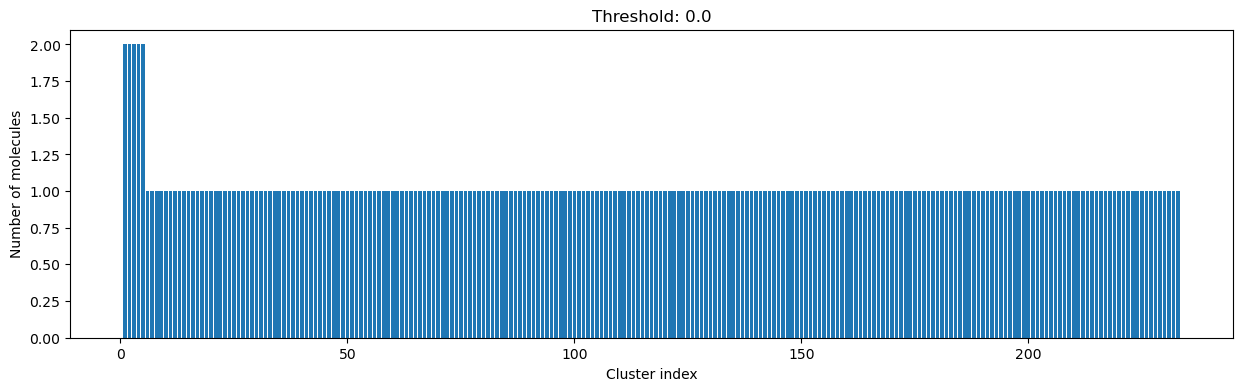

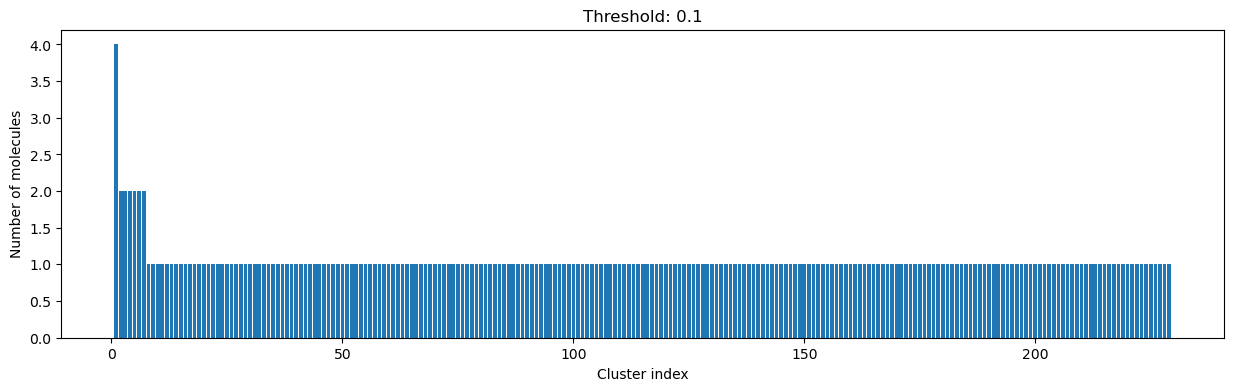

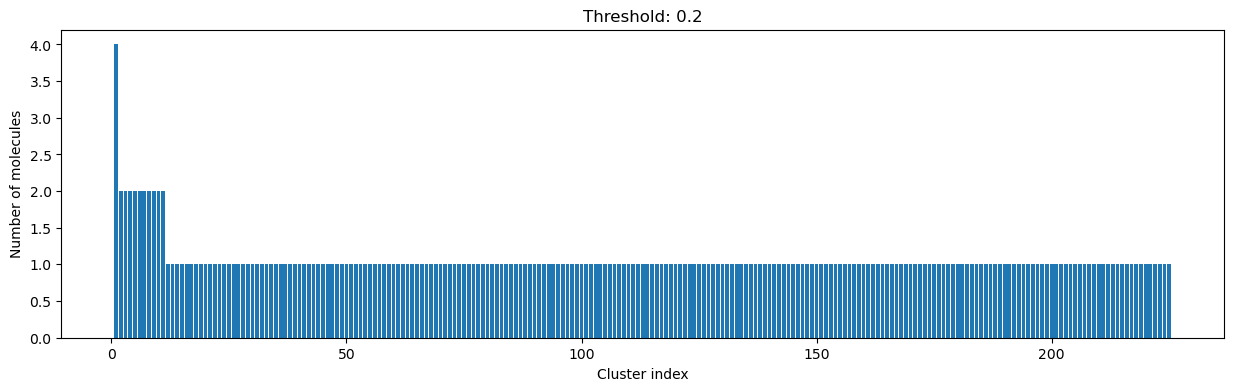

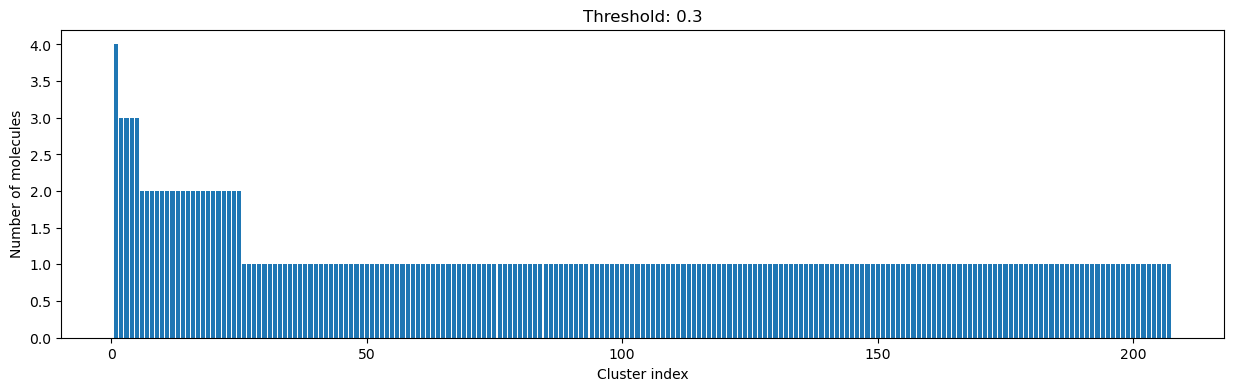

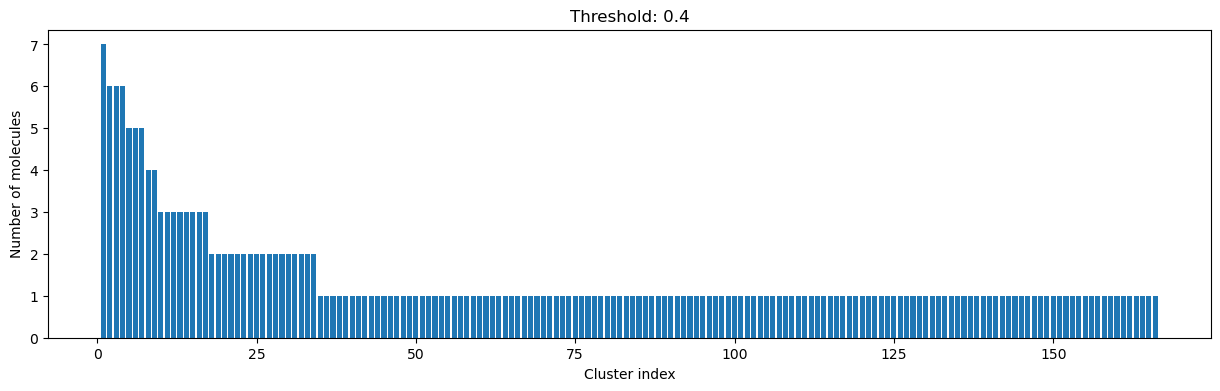

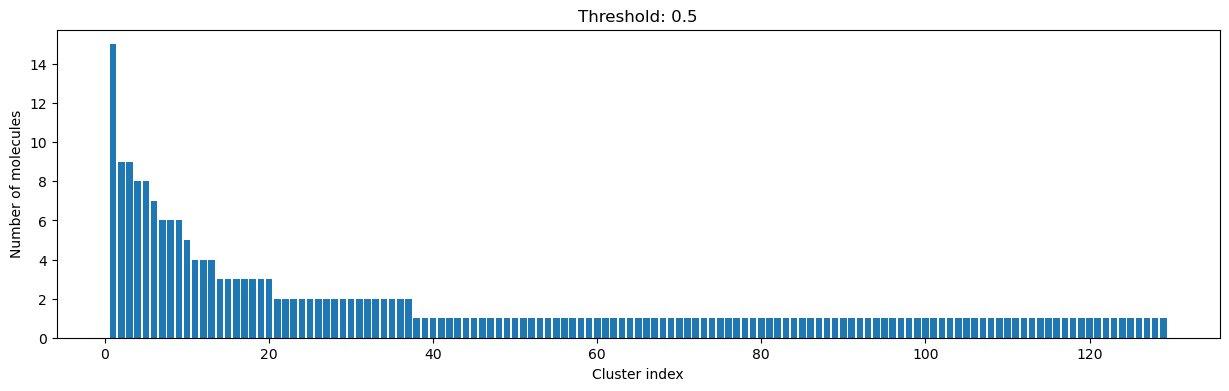

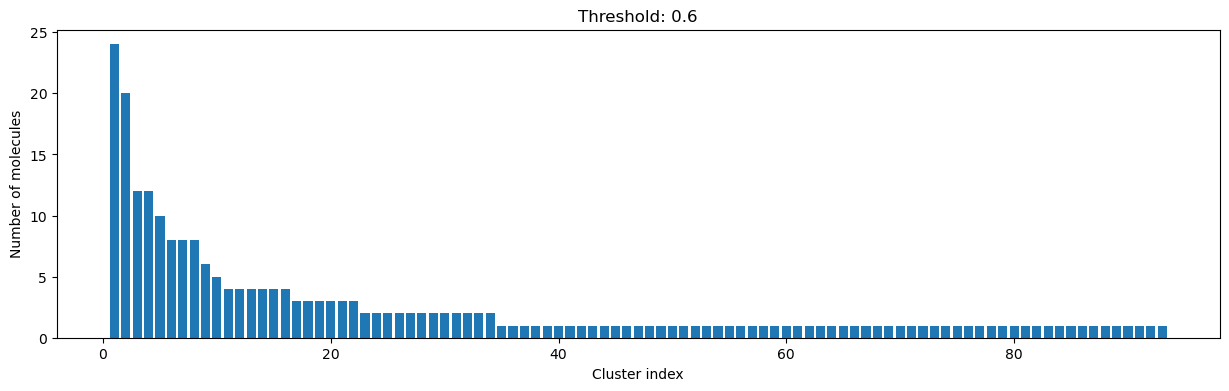

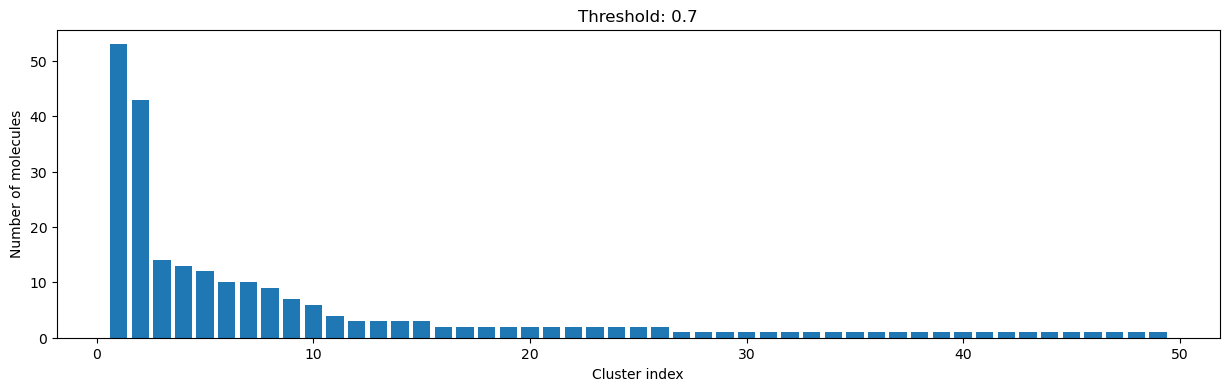

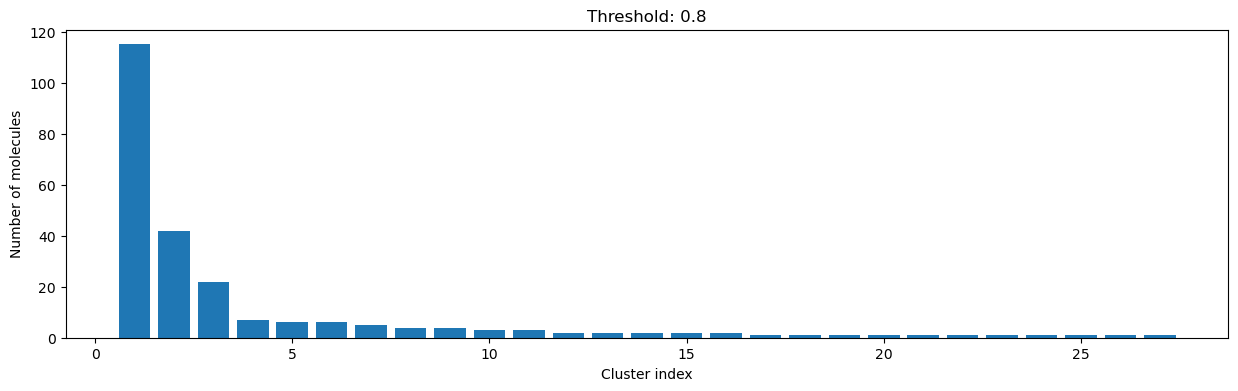

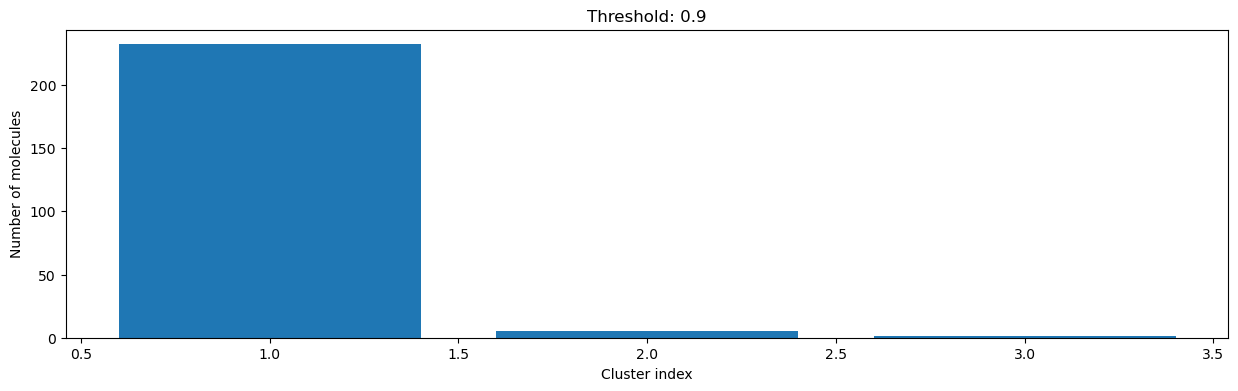

In [35]:
for cutoff in np.arange(0.0, 1.0, 0.1):
    _, cluster_dict = butina_cluster(mols, cutoff=cutoff)
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.set_title(f"Threshold: {cutoff:3.1f}")
    ax.set_xlabel("Cluster index")
    ax.set_ylabel("Number of molecules")
    ax.bar(range(1, len(cluster_dict) + 1), [len(c) for c in cluster_dict], lw=5)

Let's choose the best threshold based on the criteria we defined above. 

In [36]:
mols = antiinfl['mol'].tolist()
antiinfl['butina_cluster'], cluster_dict = butina_cluster(mols, cutoff=0.6)

Let's plot another interactive map as done before.

In [37]:
import plotly.express as px
import molplotly
fig_pca = px.scatter(antiinfl,
                     x="PCA-1",
                     y="PCA-2",
                     color='butina_cluster',
                     title='PCA of morgan fingerprints',
                     labels={'color': 'butina_cluster'},
                     width=1200,
                     height=800)

app_pca = molplotly.add_molecules(fig=fig_pca,
                                  df=antiinfl,
                                  smiles_col='Smiles',
                                  title_col='Name',
                                  caption_cols=['USAN Definition', 'cluster_opt', 'butina_cluster'],
                                  color_col='butina_cluster',
                                  show_coords=False)

app_pca.run_server(mode='inline', port=8700, height=850)


Dash is running on http://127.0.0.1:8700/



Because we have a lot of small clusters, the plot above is difficult to analyze. Let's visualize some molecules and see if the clustering makes sense to us from a chemistry perspective.

Ten molecules from largest cluster:


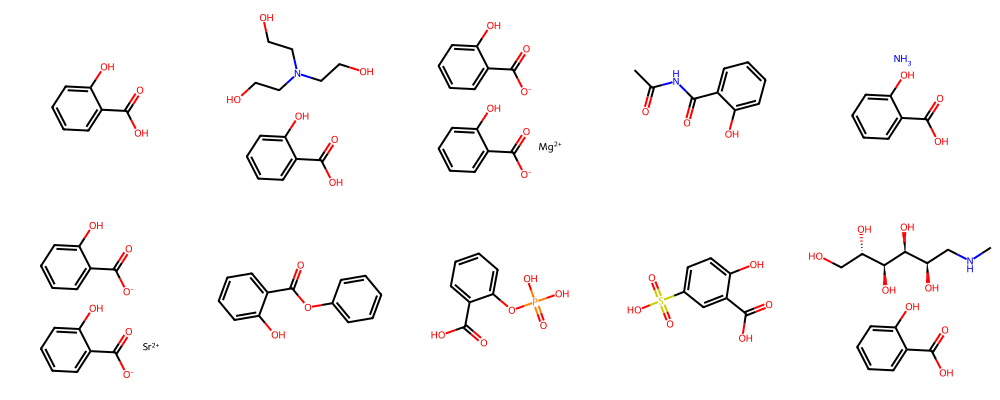

In [38]:
from rdkit.Chem import Draw
print("Ten molecules from largest cluster:")
# Draw molecules
Draw.MolsToGridImage(
    [mols[i] for i in cluster_dict[0][:10]],
    molsPerRow=5,
)

Ten molecules from second largest cluster:


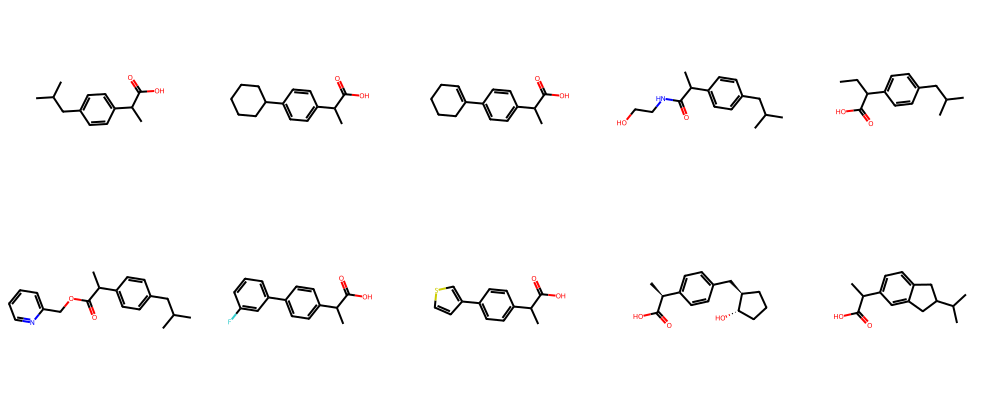

In [39]:
print("Ten molecules from second largest cluster:")
# Draw molecules
Draw.MolsToGridImage(
    [mols[i] for i in cluster_dict[1][:10]],
    molsPerRow=5,
)

Ten molecules from third largest cluster:


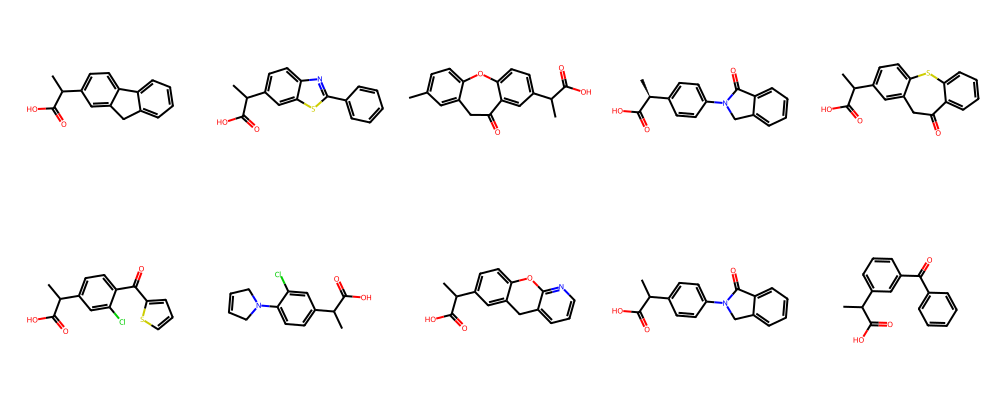

In [40]:
print("Ten molecules from third largest cluster:")
# Draw molecules
Draw.MolsToGridImage(
    [mols[i] for i in cluster_dict[2][:10]],
    molsPerRow=5,
)

I would argue that the three visualized clusters certainly show similarity between the molecules. Well done! This analysis is only one aspect and depending on the objective can be handled differently. But clustering and visualizing the data will help with getting a sense of what you are working with and if your data processing for a project can makes sense.